# Introduction

Analysis of Modules

Using the pre-prepared ARFF files, calculate and visualize various things about the ES configuration data.



## Data Format

Filenames follow the format:

    bruteforce_<D>_f<F>.arff

    | Description          | Values           |
    |----------------------|------------------|
    | Dimensionality <D>   | 2, 3, 5, 10, 20  |
    | BBOB Function ID <F> | 1, 2, 3, ..., 24 |


Data entries consist of a configuration specification $c \in \{0,1\}^9 \times \{0,1,2\}^2$ and associated quality measure $q \in [0, 2]$.<br>
Using SciPy's included `arff` reader, the data can easily be read in.


    Configuration (1-11)  | q-measure
    ----------------------+-----------------
    0,0,0,0,0,0,0,0,0,0,0 | 0.00573046875
    0,0,0,0,0,0,0,0,0,0,1 | 0.00549609375
    0,0,0,0,0,0,0,0,0,0,2 | 0.005490234375
    0,0,0,0,0,0,0,0,0,1,0 | 0.0044736328125
    [...]                 | [...]
    1,1,1,1,1,1,1,1,1,1,2 | 0.0120693359375
    1,1,1,1,1,1,1,1,1,2,0 | 0.240296875
    1,1,1,1,1,1,1,1,1,2,1 | 0.0112963867188
    1,1,1,1,1,1,1,1,1,2,2 | 0.0117387695313

## Author

Sander van Rijn &lt;svr003@gmail.com; s.j.van.rijn@liacs.leidenuniv.nl&gt; <br>
Last update: 2017-02-05

# Initialization

First cell to be run, containing all imports and default settings to be used throughout the rest of this notebook.

Some data-specific information is also pre-set here, such as the input file format, list of dimensionalities, BBOB function ID's and module names.

In [1]:
# Imports + definitions

%matplotlib inline
# %matplotlib notebook

from __future__ import division, print_function

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import networkx as nx
import numpy as np
import os
import pydotplus
import scipy.io.arff as arff

from collections import Counter
from cycler import cycler
from IPython.display import Image
from itertools import combinations, product
from matplotlib import gridspec
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu, truncnorm
from scipy.stats.stats import pearsonr
from sklearn import tree
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score



os.chdir('/media/Data/Research Data/Evolving ES data/')
# os.chdir('C:\\Users\\Sander\\surfdrive\\Research Data\\Evolving the Structure of Evolution Strategies\\experiments\\BF runs')

data_dir = 'arff/'
plot_dir = 'plots/'

np.set_printoptions(precision=4, linewidth=200)
plt.rc('axes', prop_cycle=(cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', 
                                            '#d62728', '#9467bd', '#8c564b', 
                                            '#e377c2', '#7f7f7f', '#bcbd22', 
                                            '#1f77b4', '#ff7f0e']) +
                           cycler('linestyle', ['-', '-', '-', 
                                                '-', '-', '-', 
                                                '-', '-', '-', 
                                                '--', '--'])))

fname = 'bruteforce_{}_f{}.arff'
dims = [2, 3, 5, 10, 20]
fids = range(1, 25)
experiments = product(dims, fids)
modules = ['Active', 'Elitism', 'Mirrored', 'Orthogonal', 'Sequential', 'Threshold', 'TPA', 'Pairwise', 'Weights', 'Base-Sampler', '(B)IPOP']

In [2]:
# Load all data from files into 'cases'

cases = {dim: {} for dim in dims}

for dim in dims:
    for fid in fids:
        case = arff.loadarff(data_dir + fname.format(dim, fid))[0]
        case = np.array([list(dat) for dat in case])
        cases[dim][fid] = case

# Plot the $q$-measure

Just to give an idea of what data we're dealing with: lets plot the data we have.

The cell below creates a graph for each of the 24 functions in the BBOB suite.<br>
For each dimensionality, all 4608 $q$-measure values are plotted, sorted by $q$.

In [11]:
for fid in fids:
    plt.figure(figsize=(9, 6))
    plt.title("Algorithm quality vs. Rank for F{}".format(fid))
    
    for dim in dims:
        temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,11]
        plt.plot(temp, label="{}D".format(dim))

    plt.plot([1]*temp.shape[0], 'k')
    plt.legend(loc=0)
    plt.ylim([0,2])
    plt.xlim([0,4608])
    plt.xlabel('Rank')
    plt.ylabel('Quality')
    plt.tight_layout()
            
    plt.savefig(plot_dir + "q-measures_f{}.png".format(fid))
    plt.savefig(plot_dir + "q-measures_f{}.pdf".format(fid))
    
    plt.close()

# Decision Trees

Because configurations consist of 11 choices (i.e. "should this module be on or off?"), decision<br>
trees are a very natural first step into visualizing what it means to include a module.

## Full size trees

In [12]:
features = modules

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(min_samples_split=50, min_samples_leaf=20)
        clf = clf.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])
        
        dot_data = tree.export_graphviz(clf, out_file=None,
                                        feature_names=features,
                                        class_names=['Fitness'],
                                        filled=True,
                                        rounded=True,
                                        )
        graph = pydotplus.graph_from_dot_data(dot_data)  
        graph.write_png(plot_dir + "regressor_tree_{}_f{}.png".format(dim, fid))
        # graph.write_pdf(plot_dir + "regressor_tree_{}_f{}.pdf".format(dim, fid))

As you can tell, these trees are way too big. There is basically no useful way to read<br>
anything from these trees.

Let's try smaller trees instead:

## Small trees

In [13]:
features = modules

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(max_depth=4, min_samples_split=50, min_samples_leaf=20)
        clf = clf.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])
        
        dot_data = tree.export_graphviz(clf, out_file=None,
                                        feature_names=features,
                                        class_names=['Fitness'],
                                        filled=True,
                                        rounded=True,
                                        )
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_png(plot_dir + "small_regressor_tree_{}_f{}.png".format(dim, fid))
        # graph.write_pdf(plot_dir + "small_regressor_tree_{}_f{}.pdf".format(dim, fid))

In [14]:
features = modules

best_x = 250

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(min_samples_split=20, min_samples_leaf=10)
        clf = clf.fit(cases[dim][fid][:best_x,:11], cases[dim][fid][:best_x,11])
        
        dot_data = tree.export_graphviz(clf, out_file=None,
                                        feature_names=features,
                                        class_names=['Fitness'],
                                        filled=True,
                                        rounded=True,
                                        )
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_png(plot_dir + "best_{}_regressor_tree_{}_f{}.png".format(best_x, dim, fid))
        # graph.write_pdf(plot_dir + "best_{}_regressor_tree_{}_f{}.pdf".format(best_x, dim, fid))

Even when using smaller trees, there are still just too many of them.

Besides, how good are these trees anyway? We need some numerical measures<br>
to get a better idea of how useful these trees are.

## Cross-validation score

In [11]:
scores = {dim: np.zeros(len(fids)) for dim in dims}
np.set_printoptions(precision=2, linewidth=200)

for dim in dims:
    for fid in fids:
        clf = tree.DecisionTreeRegressor(min_samples_split=50, min_samples_leaf=20)
        clf = clf.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])
        scores[dim][fid-1] = np.mean(cross_val_score(clf, cases[dim][fid][:,:11], cases[dim][fid][:,11], cv=20))

print(" 2:", scores[2])
print(" 3:", scores[3])
print(" 5:", scores[5])
print("10:", scores[10])
print("20:", scores[20])

 2: [ 0.65  0.91  0.81  0.45  0.9   0.95  0.61  0.91  0.91  0.92  0.92  0.92  0.93  0.91  0.83  0.85  0.87  0.81  0.88  0.74  0.8   0.91  0.87  0.37]
 3: [ 0.45  0.94  0.61  0.16  0.98  0.92  0.81  0.93  0.92  0.93  0.92  0.95  0.91  0.94  0.66  0.8   0.8   0.65  0.33  0.4   0.89  0.92  0.63  0.4 ]
 5: [ 0.79  0.87  0.22  0.52  0.92  0.78  0.84  0.79  0.8   0.83  0.82  0.86  0.84  0.84  0.32  0.56  0.63  0.47  0.51 -0.02  0.46  0.56  0.12  0.89]
10: [ 0.82  0.6   0.68  0.84  0.84  0.61  0.78  0.74  0.76  0.51 -0.6   0.82  0.42  0.86  0.63  0.64  0.7   0.77  0.85  0.83  0.71  0.49  0.8   0.84]
20: [ 0.87  0.8   0.67  0.69  0.85  0.58  0.64  0.69  0.74  0.77  0.1   0.83  0.73  0.83  0.68  0.89  0.74  0.78  0.8  -2.57  0.76  0.25  0.84  0.82]


Higher values mean a tree provides a good prediction/classification of the $q$-measure<br>
value based on the configuration. It's clear that some trees are good, but others not so much.

This still doesn't give any information about what each _module_ is doing to the performance.<br>
To get an idea of this, we can calculate so-called _feature importance_ for each module.

## Feature Importance based on Regressor Trees

In [27]:
importances = np.zeros((len(dims), len(fids), len(modules)))

for i_dim, dim in enumerate(dims):
    for fid in fids:
        forest = ExtraTreesRegressor(n_estimators=250, min_samples_leaf=20)
        forest = forest.fit(cases[dim][fid][:,:11], cases[dim][fid][:,11])

        importance = forest.feature_importances_
        importances[i_dim,fid-1,:] = importance

In [31]:
feature_importances = np.mean(np.mean(importances, axis=0), axis=0)
feature_indices = np.argsort(feature_importances)[::-1]

# Print the feature importances
print("Feature importances:")
for f in range(len(feature_indices)):
    print("{0: <12} & {1}".format(modules[f], feature_importances[f]))

print()

# Print the feature ranking
print("Feature ranking:")
for f in range(len(feature_indices)):
    print("{0}. feature {1: <12} ({2})".format(f + 1, modules[feature_indices[f]], feature_importances[feature_indices[f]]))

Feature importances:
Active       & 0.0667347882585
Elitist      & 0.224408908248
Mirrored     & 0.0129607089039
Orthogonal   & 0.010203203069
Sequential   & 0.0348723557566
Threshold    & 0.305258112712
TPA          & 0.137397172266
Selection    & 0.0692378745296
Weights      & 0.0536100541725
Base-Sampler & 0.0212673852032
(B)IPOP      & 0.064049436881

Feature ranking:
1. feature Threshold    (0.305258112712)
2. feature Elitist      (0.224408908248)
3. feature TPA          (0.137397172266)
4. feature Selection    (0.0692378745296)
5. feature Active       (0.0667347882585)
6. feature (B)IPOP      (0.064049436881)
7. feature Weights      (0.0536100541725)
8. feature Sequential   (0.0348723557566)
9. feature Base-Sampler (0.0212673852032)
10. feature Mirrored     (0.0129607089039)
11. feature Orthogonal   (0.010203203069)


# Scaled cumsum/count plots

## Initialization

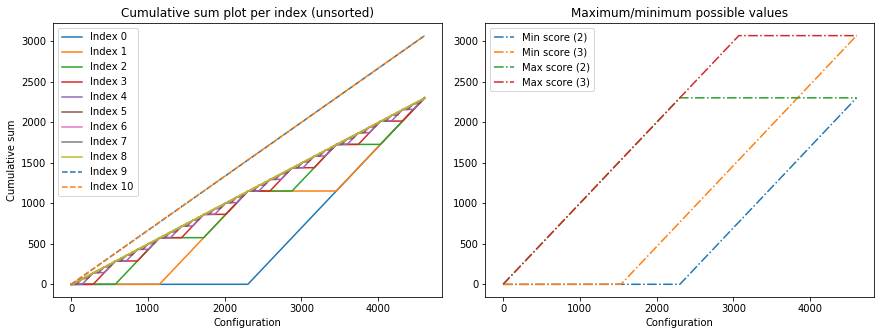

In [3]:
# Create normalization vectors for module progression plots

min_column = [0] * 2304
min_column.extend(range(1,2305))
min_column = np.array(min_column).reshape((4608,1))

max_column = range(1, 2305)
max_column.extend([2304] * 2304)
max_column = np.array(max_column).reshape((4608,1))

min_columns = np.repeat(min_column, 9, axis=1)
max_columns = np.repeat(max_column, 9, axis=1)


min_column = [0] * 1536
min_column.extend(range(1, 3073))
min_column = np.array(min_column).reshape((4608,1))

max_column = range(1, 3073)
max_column.extend([3072] * 1536)
max_column = np.array(max_column).reshape((4608,1))

min_columns = np.hstack((min_columns, min_column, min_column))
max_columns = np.hstack((max_columns, max_column, max_column))

dists = max_columns - min_columns
dists[-1,:] = 1  # Prevent division by 0

# Test/comparison for confirmation!
temp = cases[2][1][:,:11]

# replace all values '2' with '1'
two_indices = temp == 2
temp[two_indices] = 1

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_axes([0.025, 0.05, 0.45, 0.95])
ax1.set_title("Cumulative sum plot per index (unsorted)")
ax1.set_ylabel("Cumulative sum")
ax1.set_xlabel("Configuration")
lines = ax1.plot(np.cumsum(temp, axis=0))
ax1.legend(lines, ['Index {}'.format(i) for i in range(11)])

ax2 = fig.add_axes([0.525, 0.05, 0.45, 0.95])
ax2.set_xlabel("Configuration")
ax2.set_title("Maximum/minimum possible values")
lines = ax2.plot(min_columns[:,8:10], '-.')
lines2 = ax2.plot(max_columns[:,8:10], '-.')
lines.extend(lines2)
ax2.legend(lines, ['Min score (2)', 'Min score (3)', 'Max score (2)', 'Max score (3)'])
plt.show()

## Examples

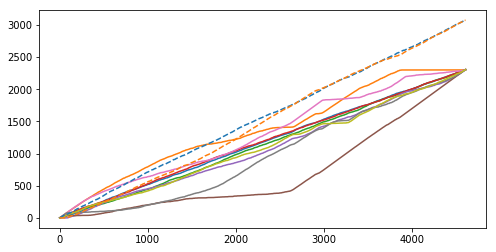

In [68]:
# Starting with the 'default' cumsum plot...

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(cases[2][1][cases[2][1][:,11].argsort()][:,:11], axis=0))
plt.show()

## Create and store scaled cumsum/count plots

In [72]:
for dim in dims:
    for fid in fids:
        temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,:11]

        # replace all values '2' with '1'
        two_indices = temp == 2
        temp[two_indices] = 1

        temp = np.cumsum(temp, axis=0)
        temp = temp - min_columns
        temp = temp / dists
        
        cutoff = 100
        
        plt.figure(figsize=(10, 4))
        plt.suptitle("Progression for {}D F{}".format(dim, fid))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
        
        ax1 = plt.subplot(gs[0])
        ax1.plot(temp[:cutoff+1,:])
        ax1.set_xlim([0, cutoff])
        ax1.set_ylabel('Relative activation frequency')
        
        ax2 = plt.subplot(gs[1], sharey=ax1)
        lines = ax2.plot(temp[cutoff//2:,:])
        ax2.set_xlim([cutoff//2,4608])
        ax2.set_xlabel('Rank')

        plt.tight_layout()
        
        plt.subplots_adjust(wspace=0, hspace=0, top=0.88)

        # Shrink current axis by 15%
        box = ax2.get_position()
        ax2.set_position([box.x0, box.y0, box.width * 0.75, box.height])
        
        # Put a legend to the right of the current axis
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=lines, labels=modules)
        
        plt.savefig(plot_dir + "module_progression_{}_f{}.png".format(dim, fid))
        plt.savefig(plot_dir + "module_progression_{}_f{}.pdf".format(dim, fid))
        
        plt.close()

# Correlation scores

## Calculations

In [4]:
# Calculate all correlations into 'correlations[5, 24, 11, 5, 24, 11]'

correlations = np.zeros((5, 24, 11, 5, 24, 11))
data = {x: {} for x in range(len(dims))}
labels = list(product(dims, fids, modules))

for a_dim, dim in enumerate(dims):
    for a_fid, fid in enumerate(fids):
        temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,:11]
    
        # replace all values '2' with '1'
        two_indices = temp == 2
        temp[two_indices] = 1
    
        temp = np.cumsum(temp, axis=0)
        temp = temp - min_columns
        temp = temp / dists
        
        data[a_dim][a_fid] = temp

for a_dim, _ in enumerate(dims):
    for a_fid, _ in enumerate(fids):
        for a_mod in range(len(modules)):
            for b_dim, _ in enumerate(dims):
                for b_fid, _ in enumerate(fids):
                    for b_mod in range(len(modules)):
                        correlations[a_dim, a_fid, a_mod, b_dim, b_fid, b_mod] = pearsonr(data[a_dim][a_fid][:, a_mod], data[b_dim][b_fid][:, b_mod])[0]
                        # correlations[b_dim, b_fid, b_mod, a_dim, a_fid, a_mod] = correlations[a_dim, a_fid, a_mod, b_dim, b_fid, b_mod]  # Symmetry!

In [21]:
# Store all correlations in csv files per module

temp_corr = correlations.reshape((len(dims)*len(fids), len(modules), len(dims)*len(fids), len(modules)))
for mod in range(11):
    np.savetxt("csv/module{}.csv".format(mod), temp_corr[:,mod,:,mod], delimiter=",")

[[ 1.      0.0795  0.14   ..., -0.0383  0.3366 -0.0957]
 [ 0.0795  1.      0.1637 ..., -0.6787 -0.6058 -0.5217]
 [ 0.14    0.1637  1.     ...,  0.1361 -0.1012  0.0265]
 ..., 
 [-0.0383 -0.6787  0.1361 ...,  1.      0.513   0.9194]
 [ 0.3366 -0.6058 -0.1012 ...,  0.513   1.      0.4427]
 [-0.0957 -0.5217  0.0265 ...,  0.9194  0.4427  1.    ]]


## Visualisations

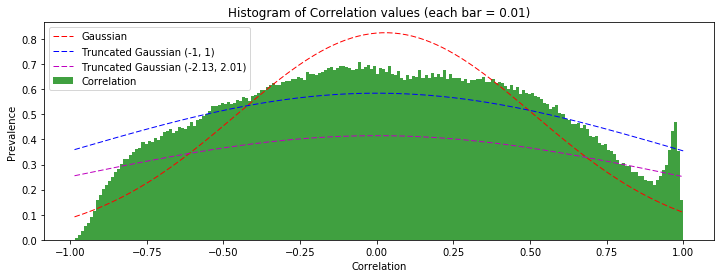

In [38]:
# Visualize the distribution of correlation values as a histogram (+ expected gaussian to see if they are actually interesting)

x = correlations.reshape((len(dims)*len(fids)*len(modules)*len(dims)*len(fids)*len(modules), ))
mu = np.mean(x)
std = np.std(x)

plt.figure(figsize=(12,4))
plt.title('Histogram of Correlation values (each bar = 0.01)')
n, bins, patches = plt.hist(x, 200, normed=1, facecolor='green', alpha=0.75, label='Correlation')
y = mlab.normpdf(bins, mu, std)
l = plt.plot(bins, y, 'r--', linewidth=1, label='Gaussian')

tn = truncnorm(-1, 1)
y = tn.pdf(bins)
l = plt.plot(bins, y, 'b--', linewidth=1, label='Truncated Gaussian (-1, 1)')
a, b = (-1 - mu) / std, (1 - mu) / std
tn = truncnorm(a, b)
y = tn.pdf(bins)
l = plt.plot(bins, y, 'm--', linewidth=1, label='Truncated Gaussian (-2.13, 2.01)')
plt.xlabel('Correlation')
plt.ylabel('Prevalence')
plt.legend(loc=0)
plt.show()

In [39]:
# Create one giant heatmap (1320*1320)

x = np.arange(len(dims)*len(fids)*len(modules) + 1)
y = np.arange(len(dims)*len(fids)*len(modules) + 1)
X, Y = np.meshgrid(x, y)

temp_corr = correlations.reshape((len(dims)*len(fids)*len(modules), len(dims)*len(fids)*len(modules)))


plt.figure(figsize=(16,12))
plt.pcolor(X, Y, temp_corr, cmap='viridis', vmin=-1, vmax=1)
plt.title("Inter-module behavior correlation")
plt.colorbar(label='Correlation')
plt.xlim([0,len(dims)*len(fids)*len(modules)])
plt.ylim([0,len(dims)*len(fids)*len(modules)])
plt.tight_layout()
plt.savefig("plots/correlation_heatmap.png")
# plt.savefig("plots/correlation_heatmap.pdf")
plt.close()

In [9]:
# Create heatmaps per module (120*120)

x = np.arange(len(dims)*len(fids) + 1)
y = np.arange(len(dims)*len(fids) + 1)
X, Y = np.meshgrid(x, y)

temp_corr = correlations.reshape((len(dims)*len(fids), len(modules), len(dims)*len(fids), len(modules)))

for mod in range(11):
    plt.figure(figsize=(8,6))
    plt.pcolor(X, Y, temp_corr[:,mod,:,mod], cmap='viridis', vmin=-1, vmax=1)
    plt.title("Behavior correlation for module '{}'".format(modules[mod]))
    plt.xlabel('Experiment')
    plt.ylabel('Experiment')
    plt.xticks([0.5, 11.5, 24.5, 35.5, 48.5, 59.5, 72.5, 83.5, 96.5, 107.5, 119.5], 
               ['2D F1', '2D F12', '3D F1', '3D F12', '5D F1', '5D F12', '10D F1', '10D F12', '20D F1', '20D F12', '20D F24'], rotation='vertical')
    plt.yticks([0.5, 11.5, 24.5, 35.5, 48.5, 59.5, 72.5, 83.5, 96.5, 107.5, 119.5], 
               ['2D F1', '2D F12', '3D F1', '3D F12', '5D F1', '5D F12', '10D F1', '10D F12', '20D F1', '20D F12', '20D F24'])
    plt.colorbar(label='Correlation')
    plt.tight_layout()
    plt.savefig(plot_dir + "correlation_heatmap_{}.png".format(modules[mod]))
    plt.savefig(plot_dir + "correlation_heatmap_{}.pdf".format(modules[mod]))
    plt.close()

## Clustering 

### Clustering function definitions

In [111]:
# Cluster creation function definition. Creates clusters by making a graph out of all (dim, fid, mod) pairs that are correlated

def cluster_correlation_as_components(corr, corr_filter=0.99, min_size=3):
    temp = np.triu(corr.reshape((1320, 1320)), k=1)

    high_corr = temp > corr_filter
    high_corr_ind = np.argwhere(high_corr)

    G = nx.Graph()
    G.add_edges_from(high_corr_ind)
    print("Number of edges:                ", len(high_corr_ind))
    print("Number of connected components: ", nx.number_connected_components(G))
    print([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

    clusters = [c for c in sorted(nx.connected_components(G), key=len, reverse=True) if len(c) >= min_size]
    print(len(clusters))
    
    return clusters

In [123]:
# Cluster plotting function definition

def create_and_save_progression_clusters(clusters, corr_vals, cluster_type='', ignore_triples=False, legend_limit=10):
    if len(cluster_type) > 0:
        
        if cluster_type == 'naive':
            title_name = 'naive'
        elif cluster_type == 'mod-coop':
            title_name = 'module cooperation'
        elif cluster_type == 'exp-sim':
            title_name = 'experiment similarity'
        else:
            title_name = cluster_type
        
        cluster_type = cluster_type + '_'

    cutoff = 100
    for clust_num, cluster in enumerate(clusters):

        cluster_corr_indices = np.array(list(combinations([case for case in cluster], 2)))
        cluster_corr_vals = [corr_vals.reshape((1320, 1320))[a, b] for a, b in cluster_corr_indices]
        min_corr_val = np.min(cluster_corr_vals)
        
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])
        plt.figure(figsize=(7.5, 3))
        plt.suptitle("Progression for {0} cluster (c > {1:.3f})".format(title_name, min_corr_val))

        clust_labels = []
        clust_lines = []
        for case in cluster:
            dim, fid, mod = labels[case]
            if ignore_triples is True and mod in ['Base-Sampler', '(B)IPOP']:
                continue

            mod = modules.index(mod)
            temp = cases[dim][fid][ cases[dim][fid][:,11].argsort() ][:,mod]
            temp[temp == 2] = 1  # replace all values '2' with '1'

            temp = np.cumsum(temp, axis=0)
            temp = temp - min_columns[:,mod]
            temp = temp / dists[:,mod]

            ax1 = plt.subplot(gs[0])
            ax1.plot(temp[:cutoff+1])
            ax2 = plt.subplot(gs[1], sharey=ax1)
            
            clust_lines.extend(ax2.plot(temp[cutoff//2:]))
            clust_labels.append("{} ({}D F{})".format(modules[mod], dim, fid))

        ax1.set_xlim([0, cutoff])
        ax1.set_ylim([0,1])
        ax1.set_ylabel('Relative activation frequency')
        ax2.set_xlim([cutoff//2,4608])
        ax2.set_xlabel('Rank')

        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0, top=0.88)

        if len(cluster) < legend_limit:
            # Shrink current axis to make room for a legend to the right of it
            # box = ax2.get_position()
            # ax2.set_position([box.x0, box.y0, box.width * 0.75, box.height])
            ax2.legend(loc=0, handles=clust_lines, labels=clust_labels)

        plt.savefig(plot_dir + "module_progression_{}cluster_{}_{}.png".format(cluster_type, clust_num, len(clusters)))
        plt.savefig(plot_dir + "module_progression_{}cluster_{}_{}.pdf".format(cluster_type, clust_num, len(clusters)))

        plt.close()

### Naive clustering

In [113]:
# Naive cluster creation

# 0.95: 14762, 0.99: 733, 0.9925: 314 0.995: 114, 0.999: 9, 0.9999: 0
corr_filter_val = 0.9925
clusters = cluster_correlation_as_components(correlations, corr_filter=corr_filter_val)

Number of edges:                 314
Number of connected components:  55
[67, 19, 15, 7, 6, 6, 6, 6, 5, 5, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
15


In [120]:
# Plot the naive clusters

create_and_save_progression_clusters(clusters, correlations, 'naive')

### Module Cooperation clustering

In [129]:
# Create clusters on 'Module Cooperation'
print("Module Cooperation (experiment fixed)")

# Create a copy of all correlation values artificially reduced by 1
mod_coop_corr = correlations.copy() - 1

# Restore the correct correlation values of all cases we are actually interested in
for dim in range(len(dims)):
    for fid in range(len(fids)):
        mod_coop_corr[dim, fid, :, dim, fid, :] = mod_coop_corr[dim, fid, :, dim, fid, :] + 1

mod_coop_filter_val = 0.9
mod_coop_clusters = cluster_correlation_as_components(mod_coop_corr, corr_filter=mod_coop_filter_val, min_size=2)

Module Cooperation (experiment fixed)
Number of edges:                 124
Number of connected components:  110
[4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
110


In [131]:
# Create clustered progression plots
create_and_save_progression_clusters(mod_coop_clusters, mod_coop_corr, 'mod-coop')

### Experiment Similarity Clustering

In [128]:
# Create clusters on 'Experiment Similarity'
print("Experiment similarity (module fixed)")

# Create a copy of all correlation values artificially reduced by 1
exp_sim_corr = correlations.copy() - 1

# Restore the correct correlation values of all cases we are actually interested in
for mod in range(len(modules)):
    exp_sim_corr[:, :, mod, :, :, mod] = exp_sim_corr[:, :, mod, :, :, mod] + 1

exp_sim_filter_val = 0.9925
exp_sim_clusters = cluster_correlation_as_components(exp_sim_corr, corr_filter=exp_sim_filter_val)

Experiment similarity (module fixed)
Number of edges:                 276
Number of connected components:  61
[57, 15, 9, 8, 6, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
17


In [124]:
# Create clustered progression plots
create_and_save_progression_clusters(exp_sim_clusters, exp_sim_corr, 'exp-sim')

# Impact scores

## Single module

Attempt at creating an impact score per module:<br>
Calculate average fitness for when a module is on and off, then subtract 'on' from 'off'.<br>
If the a module has a positive impact, it will have a positive impact score

In [7]:
single_impact = np.zeros((len(dims), len(fids), len(modules)))
single_significance = np.zeros((len(dims), len(fids), len(modules)))
impact_calc_data = {dim: {fid: {} for fid in fids} for dim in dims}

for i_dim, dim in enumerate(dims):
    for fid in fids:
        temp = cases[dim][fid]
        
        for mod in range(len(modules)):
            indices_on = temp[:,mod] > 0
            indices_off = temp[:,mod] < 1

            impact_calc_data[dim][fid][mod] = (temp[indices_on,11], temp[indices_off,11])
            
            mean_on = np.mean(temp[indices_on,11])
            mean_off = np.mean(temp[indices_off,11])
            
            single_impact[i_dim, fid-1, mod] = mean_off - mean_on
            single_significance[i_dim, fid-1, mod] = mannwhitneyu(temp[indices_on,11],
                                                                  temp[indices_off,11],
                                                                  alternative='two-sided')[1]
            

avg_impact = np.mean(np.mean(single_impact, axis=0), axis=0)
avg_p_value = np.mean(np.mean(single_significance, axis=0), axis=0)


print("Module name |   Total Impact      Mean Impact     | Total p-value        Mean p-value    ")
print("-----------------------------------------------------------------------------------------")
for mod in range(len(modules)):
    data_on, data_off = zip(*[impact_calc_data[dim][fid][mod] for dim in dims for fid in fids])
    data_on = np.array(data_on).reshape((-1,1))
    data_off = np.array(data_off).reshape((-1,1))
    
    total_impact = np.mean(data_off) - np.mean(data_on)
    total_p_value = mannwhitneyu(data_on, data_off, alternative='two-sided')[1]
    
    print("{0: <12}| {1: >16} {2: 18} | {3: <20} {4: <16}".format(modules[mod],
          total_impact, avg_impact[mod],
          total_p_value, avg_p_value[mod]))

Module name |   Total Impact      Mean Impact     | Total p-value        Mean p-value    
-----------------------------------------------------------------------------------------
Active      |   -0.12603970585     -0.12603970585 | 0.0                  0.184086465655  
Elitist     |   0.274163653035     0.274163653035 | 0.0                  0.00700419500345
Mirrored    |  0.0113576646795    0.0113576646795 | 6.60541546106e-10    0.157874900177  
Orthogonal  |   0.022634543826     0.022634543826 | 8.71737223597e-43    0.269650239341  
Sequential  |  -0.102557959514    -0.102557959514 | 0.0                  0.010687748122  
Threshold   |  -0.491054282784    -0.491054282784 | 0.0                  9.53721263181e-15
TPA         |   0.070425108658     0.070425108658 | 0.0                  0.0514134993331 
Selection   | -0.0275808280011   -0.0275808280011 | 3.13207131766e-43    0.0445164841291 
Weights     |  -0.121672952006    -0.121672952006 | 0.0                  0.00131316108857
Base-Samp

In [8]:
imps = single_impact.reshape((-1,1))
sigs = single_significance.reshape((-1,1))

neg_imps = imps < -.133
pos_imps = imps > .229

print("Max p-value:            {} out of {} values".format(max(sigs)[0], len(sigs)))
print("Max p-value I < -0.133: {} out of {} values".format(max(sigs[neg_imps]), len(sigs[neg_imps])))
print("Max p-value I >  0.229: {} out of {} values".format(max(sigs[pos_imps]), len(sigs[pos_imps])))

Max significance:            0.999929318648 out of 1320 values
Max significance I < -0.133: 7.6305619424e-05 out of 231 values
Max significance I >  0.229: 1.14446551582e-12 out of 93 values


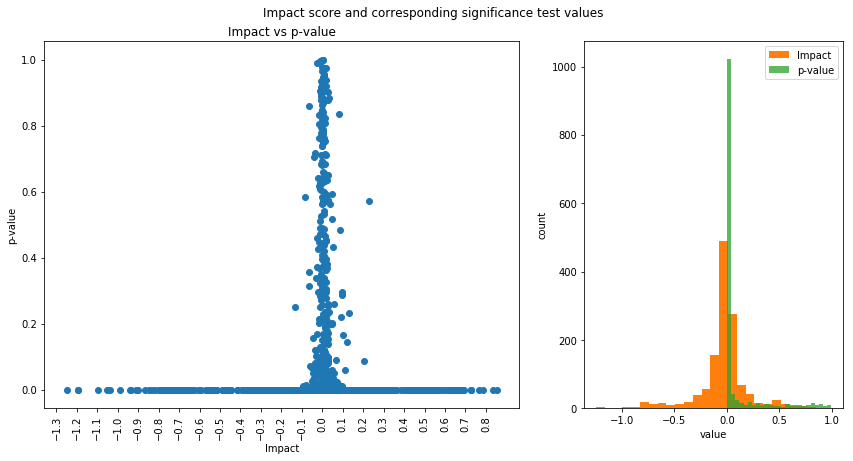

In [9]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('Impact score and corresponding significance test values')

ax1 = fig.add_axes([0.05, 0.05, 0.55, 0.85])
ax1.set_title('Impact vs p-value')
ax1.scatter(single_impact.reshape((-1,1)), single_significance.reshape((-1,1)))
ax1.set_xlabel('Impact')
ax1.set_ylabel('p-value')
ax1.set_xticks(np.arange(-1.3, 0.9, 0.1))
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90)

ax2 = fig.add_axes([0.675, 0.05, 0.3, 0.85])
ax2.set_xlabel('value')
ax2.set_ylabel('count')
ax2.hist(single_impact.reshape((-1,1)), 25, facecolor='#ff7f0e', label='Impact')
# ax2.legend(loc=0)

# ax3 = fig.add_axes([0.675, 0.525, 0.3, 0.375])
# ax3.set_xlabel('value')
# ax3.set_ylabel('count')
ax2.hist(single_significance.reshape((-1,1)), 25, facecolor='#2ca02c', alpha=0.75, label='p-value')
ax2.legend(loc=0)

# fig.tight_layout()
plt.savefig(plot_dir + "impact_vs_p-value.png")
plt.savefig(plot_dir + "impact_vs_p-value.pdf")
plt.show()

In [19]:
x = np.arange(len(fids)+1)
y = np.arange(len(dims)+1)
X, Y = np.meshgrid(x, y)

minval = np.min(single_impact)
maxval = np.max(single_impact)


for mod in range(len(modules)):
    plt.figure(figsize=(6,3))
    plt.pcolor(X, Y, single_impact[:,:,mod], cmap='viridis', vmin=minval, vmax=maxval)
    plt.title("Impact of {} module".format(modules[mod]))
    plt.colorbar(label='Impact')
    plt.xlim([0,24])
    plt.ylabel("Dimension")
    plt.yticks([.5, 1.5, 2.5, 3.5, 4.5], ['2', '3', '5', '10', '20'])
    plt.xticks(np.arange(len(fids))+.5, np.arange(len(fids))+1)
    plt.xlabel("Function")
    plt.tight_layout()
    plt.savefig(plot_dir + "impact_heatmap_{}.png".format(modules[mod]))
    plt.savefig(plot_dir + "impact_heatmap_{}.pdf".format(modules[mod]))
    plt.close()

-1.25016088099 0.853054811624


In [23]:
### TODO ###
# Improve this approach using
# https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
### END-TODO ###

x = np.arange(len(fids)+1)
y = np.arange(len(dims)+1)
X, Y = np.meshgrid(x, y)

minval = np.min(single_impact)
maxval = np.max(single_impact)

plt.figure(figsize=(6,9))
for subplot, mod in enumerate([5, 10, 1]):  # Threshold, (B)IPOP and Elitist
    plt.subplot(3, 1, subplot+1)
    plt.pcolor(X, Y, single_impact[:,:,mod], cmap='viridis', vmin=minval, vmax=maxval)
    plt.title("Impact of {} module".format(modules[mod]))
    plt.xlim([0,24])
    plt.ylabel("Dimension")
    plt.yticks([.5, 1.5, 2.5, 3.5, 4.5], ['2', '3', '5', '10', '20'])
    plt.xticks(np.arange(len(fids))+.5, np.arange(len(fids))+1)
    plt.xlabel("Function")

plt.colorbar(label='Impact')
plt.tight_layout()
plt.savefig(plot_dir + "impact_heatmap.png")
plt.savefig(plot_dir + "impact_heatmap.pdf")
plt.close()

## Module interaction

In [8]:
nand_impact = np.zeros((len(dims), len(fids), len(modules), len(modules)))
nor_impact = np.zeros((len(dims), len(fids), len(modules), len(modules)))

nand_significance = np.zeros((len(dims), len(fids), len(modules), len(modules)))
nor_significance = np.zeros((len(dims), len(fids), len(modules), len(modules)))
np.set_printoptions(precision=3, linewidth=200, suppress=True)

for i_dim, dim in enumerate(dims):
    for fid in fids:
        temp = cases[dim][fid]
        
        for A_mod in range(len(modules)):
            A_indices_on = temp[:,A_mod] > 0
            A_indices_off = temp[:,A_mod] < 1
            
            for B_mod in range(len(modules)):
                B_indices_on = temp[:,B_mod] > 0
                B_indices_off = temp[:,B_mod] < 1
                
                indices_on = np.logical_and(A_indices_on, B_indices_on)
                indices_off_nand = np.logical_and(A_indices_off, B_indices_off)
                indices_off_nor = np.logical_or(A_indices_off, B_indices_off)
                
                mean_on = np.mean(temp[indices_on,11])
                mean_off = np.mean(temp[indices_off_nand,11])
                nand_impact[i_dim, fid-1, A_mod, B_mod] = mean_off - mean_on

                nand_significance[i_dim, fid-1, A_mod, B_mod] = mannwhitneyu(temp[indices_on,11],
                                                                             temp[indices_off_nand,11],
                                                                             alternative='two-sided')[1]
                nor_significance[i_dim, fid-1, A_mod, B_mod] = mannwhitneyu(temp[indices_on,11],
                                                                            temp[indices_off_nor,11],
                                                                            alternative='two-sided')[1]
                
                mean_off = np.mean(temp[indices_off_nor,11])
                nor_impact[i_dim, fid-1, A_mod, B_mod] = mean_off - mean_on

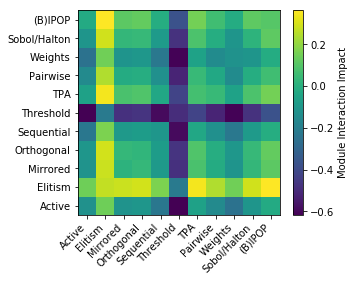

-0.0162231633216 -0.00198211186869


In [35]:
def create_and_save_interaction_impact(impacts, vmin=None, vmax=None, save=True, show=False, cmap='viridis',k,
                                       impact_type='nand', extra_save_info='', title=None):

    x = np.arange(len(modules)+1)
    y = np.arange(len(modules)+1)
    X, Y = np.meshgrid(x, y)

    plt.figure(figsize=(5,4))
    
    if title is not None:
        plt.title(title)
    
    plt.pcolor(X, Y, impacts, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(label='Module Interaction Impact')
    plt.xlim([0,len(modules)])
    plt.ylim([0,len(modules)])
    plt.xticks(np.arange(len(modules)) + 0.5, modules, rotation=45, horizontalalignment='right')
    plt.yticks(np.arange(len(modules)) + 0.5, modules)
    plt.tight_layout()
    
    if save:
        plt.savefig(plot_dir + "{}_impact_heatmap{}.png".format(impact_type, extra_save_info))
        plt.savefig(plot_dir + "{}_impact_heatmap{}.pdf".format(impact_type, extra_save_info))
    
    if show:
        plt.show()
    else:
        plt.close()

create_and_save_interaction_impact(np.mean(np.mean(nand_impact, axis=0), axis=0), save=True, show=True)

print(np.mean(np.mean(nand_impact, axis=0), axis=0)[2, 7], np.mean(np.mean(nor_impact, axis=0), axis=0)[2, 7])

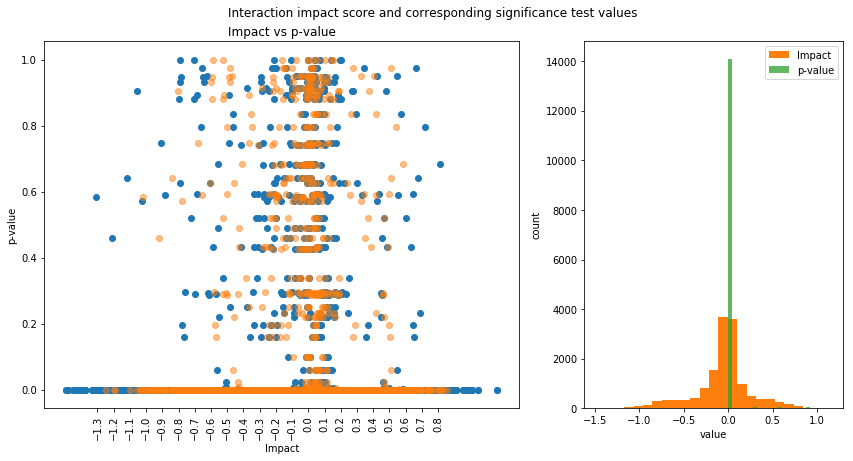

In [14]:
# Interaction impact vs p-value

fig = plt.figure(figsize=(12,6))
fig.suptitle('Interaction impact score and corresponding significance test values')

ax1 = fig.add_axes([0.05, 0.05, 0.55, 0.85])
ax1.set_title('Impact vs p-value')
ax1.scatter(nand_impact.reshape((-1,1)), nand_significance.reshape((-1,1)), label='\'nand\' Impact')
ax1.scatter(nor_impact.reshape((-1,1)), nor_significance.reshape((-1,1)), alpha=0.5, label='\'nor\' Impact')
ax1.set_xlabel('Impact')
ax1.set_ylabel('p-value')
ax1.set_xticks(np.arange(-1.3, 0.9, 0.1))
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90)

ax2 = fig.add_axes([0.675, 0.05, 0.3, 0.85])
ax2.set_xlabel('value')
ax2.set_ylabel('count')
ax2.hist(nand_impact.reshape((-1,1)), 25, facecolor='#ff7f0e', label='Impact')
# ax2.legend(loc=0)

# ax3 = fig.add_axes([0.675, 0.525, 0.3, 0.375])
# ax3.set_xlabel('value')
# ax3.set_ylabel('count')
ax2.hist(nand_significance.reshape((-1,1)), 25, facecolor='#2ca02c', alpha=0.75, label='p-value')
ax2.legend(loc=0)

# fig.tight_layout()
plt.savefig(plot_dir + "impact_vs_p-value.png")
plt.savefig(plot_dir + "impact_vs_p-value.pdf")
plt.show()

In [25]:
# Some statistics about the occurring p-values

nand_imps = nand_impact.reshape((-1,1))
nand_sigs = nand_significance.reshape((-1,1))

nor_imps = nor_impact.reshape((-1,1))
nor_sigs = nor_significance.reshape((-1,1))

sig_level = 0.05

nand_sig = nand_sigs < sig_level
nor_sig = nor_sigs < sig_level

print("Max nor p-value:        {} out of {} values".format(max(nor_sigs)[0], len(nor_sigs)))
print("Number of significant nor values (P < {}):  {} values".format(sig_level, len(nor_imps[nor_sig])))
print(np.argwhere(nand_significance > sig_level))
print()
print("Max nand p-value:       {} out of {} values".format(max(nand_sigs)[0], len(nand_sigs)))
print("Number of significant nand values (P < {}): {} values".format(sig_level, len(nand_imps[nand_sig])))
print(np.argwhere(nor_significance > sig_level))

Max nor p-value:        0.999034775715 out of 14520 values
Number of significant nor values (P < 0.05):  14102 values
[[ 0  1 10  0]
 [ 0  1 10  1]
 [ 0  1 10  2]
 ..., 
 [ 4 19 10  8]
 [ 4 19 10  9]
 [ 4 19 10 10]]

Max nand p-value:       0.999034775715 out of 14520 values
Number of significant nand values (P < 0.05): 14102 values
[[ 0  1 10  0]
 [ 0  1 10  1]
 [ 0  1 10  2]
 ..., 
 [ 4 19 10  8]
 [ 4 19 10  9]
 [ 4 19 10 10]]


In [38]:
x = np.arange(len(modules)+1)
y = np.arange(len(modules)+1)
X, Y = np.meshgrid(x, y)

minval = np.min(np.mean(nand_impact, axis=0))
maxval = np.max(np.mean(nand_impact, axis=0))


for fid in range(len(fids)):
        
    create_and_save_interaction_impact(np.mean(nand_impact[:,fid,:,:], axis=0), vmin=minval, vmax=maxval,
                                       extra_save_info='_f{}'.format(fids[fid]),
                                       title="Impact of module interaction for F{}".format(fids[fid]))

    create_and_save_interaction_impact(np.mean(nand_impact[:,fid,:,:], axis=0), cmap='plasma',
                                       extra_save_info='_f{}_plasma'.format(fids[fid]),
                                       title="Impact of module interaction for F{}".format(fids[fid]))

In [39]:
minval = np.min(nand_impact)
maxval = np.max(nand_impact)


for dim in range(len(dims)):
    for fid in range(len(fids)):
        
        create_and_save_interaction_impact(nand_impact[dim,fid,:,:], vmin=minval, vmax=maxval,
                                           extra_save_info='_{}_f{}'.format(dims[dim], fids[fid]),
                                           title="Impact of module interaction for {}D F{}".format(dims[dim], fids[fid]))

        create_and_save_interaction_impact(nand_impact[dim,fid,:,:], cmap='plasma',
                                           extra_save_info='_{}_f{}_plasma'.format(dims[dim], fids[fid]),
                                           title="Impact of module interaction for {}D F{}".format(dims[dim], fids[fid]))